# Playing with Variational Autoencoders

In [1]:
import os

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_probability as tfp

from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.auto import tqdm, trange

In [2]:
tfd = tfp.distributions

sns.set_context('talk')

## Glossary

* epoch: one cycle through training data (made up of many steps)
* step: one gradient update per batch of data
* learning rate: how fast to follow gradient (in gradient descent)

* neural network: find function $y = f(x)$ with features $x$ and values/labels $y$ (regression/classification)
* autoencoder:
    * find function mapping $x$ to itself: $z = f(h_e(x))$, $\hat{x} = f(h_d(z))$
    * undercomplete: $dim(latent\ space) < dim(input\ space)$ (vs overcomplete)
    * problem of capacity:
        * if encoder is too powerful, one dimensional latent space could encode all training samples -> autoencoder fails to learn anything useful
    * regularized: sophisticated loss-function (sparsity, robustness, ...)
    * variational: enforce distribution for latent space

## Introduction

### Basic operations

In [3]:
a = tf.constant(2.)
b = tf.constant(3.)

print(tf.add(a, b))
print(tf.reduce_mean([a, b]))

tf.Tensor(5.0, shape=(), dtype=float32)
tf.Tensor(2.5, shape=(), dtype=float32)


In [4]:
m1 = tf.constant([[1., 2.], [3., 4.]])
m2 = tf.constant([[5., 6.], [7., 8.]])

tf.matmul(m1, m2)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[19., 22.],
       [43., 50.]], dtype=float32)>

## Variational Autoencoder

### Theory

Given data $X$, latent variable $z$, probability distribution of data $P(X)$, p.d. of latent variable $P(z)$, p.d. of generated data given latent variable $P(X|z)$

Goal is to model data, i.e. find $P(X) = \int P(X|z) P(z)$

Idea of VAE:

* infer $P(z)$ from $P(z|X)$ using variational inference (inference as optimization problem)
* model $P(z|X)$ using $Q(z|X)$, $Q$ is typically Gaussian
* components:
    * encoder: $Q(z|X)$
    * decoder: $P(X|z)$

Measure difference between two distributions: Kullback–Leibler divergence

Objective function:
$$
\log P(X)-D_{K L}[Q(z | X) \| P(z | X)]=E[\log P(X | z)]-D_{K L}[Q(z | X) \| P(z)]
$$

### Design model

In [5]:
class Encoder(tf.keras.layers.Layer):
    """Convert input to low-dimensional representation."""

    def __init__(self, latent_dim, original_dim):
        super(Encoder, self).__init__()
        self.network = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(*original_dim, 1)),

            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation=tf.nn.relu),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation=tf.nn.relu),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(units=2*latent_dim)
        ])

    def call(self, x):
        return self.network(x)


class Decoder(tf.keras.layers.Layer):
    """Reconstruct input from low-dimensional representation."""

    def __init__(self, latent_dim, original_dim):
        super(Decoder, self).__init__()
        self.network = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),

            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=(2, 2), padding='SAME', activation=tf.nn.relu),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=(2, 2), padding='SAME', activation=tf.nn.relu),

            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=(1, 1), padding='SAME'),
        ])

    def call(self, z):
        return self.network(z)


class Autoencoder(tf.keras.Model):
    """Connect all components to single model."""

    def __init__(self, latent_dim, original_dim):
        """Initialize everything."""
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim

        # setup architecture
        self._encoder = Encoder(
            latent_dim=self.latent_dim, original_dim=original_dim)
        self._decoder = Decoder(
            latent_dim=self.latent_dim, original_dim=original_dim)

        # helpful stuff
        self.train_loss = tf.keras.metrics.Mean(name='train_loss')

    def encode(self, x):
        """Input -> latent distribution."""
        mean, logvar = tf.split(self._encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def _reparameterize(self, mean, logvar):
        """Trick which is needed for backpropagation."""
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z):
        """Latent -> input space."""
        return self._decoder(z)

    def call(self, x):
        """Generate distribution from input and reconstruct using it."""
        mu, _ = tf.split(self._encoder(x), num_or_size_splits=2, axis=1)
        # why do we only pass mu?
        reconstructed = self.decode(mu)
        return reconstructed

    def log_normal_pdf(self, sample, mean, logvar, raxis=1):
        log2pi = tf.math.log(2. * np.pi)
        return tf.reduce_sum(
            -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
            axis=raxis)

    def compute_loss(self, x):
        """ Compute loss.

            Hmmmmm
        """
        mean, logvar = self.encode(x)
        z = self._reparameterize(mean, logvar)
        x_logit = self.decode(z)

        cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
        logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
        logpz = self.log_normal_pdf(z, 0., 0.)
        logqz_x = self.log_normal_pdf(z, mean, logvar)

        return -tf.reduce_mean(logpx_z + logpz - logqz_x)

    def compute_gradients(self, x):
        with tf.GradientTape() as tape:
            loss = self.compute_loss(x)
            self.train_loss(loss)

            return tape.gradient(loss, self.trainable_variables)

    @tf.function
    def train(self, x, optimizer):
        gradients = self.compute_gradients(x)
        optimizer.apply_gradients(zip(gradients, self.trainable_variables))

    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps)

    def save(self, fname):
        """Save model.
            https://www.tensorflow.org/alpha/guide/keras/saving_and_serializing#saving_subclassed_models
        """
        os.makedirs(os.path.dirname(fname), exist_ok=True)
        self.save_weights(fname, save_format='tf')

    @classmethod
    def load_from_file(cls, fname):
        model = cls(latent_dim, original_dim)  # TODO: load parameters from file

        # train model briefly to infer architecture
        # TODO

        model.load_weights(fname)
        return model

### Run model

#### Parameters

In [6]:
np.random.seed(1)
tf.random.set_seed(1)

In [7]:
batch_size = 128
epochs = 15
learning_rate = 1e-3
latent_dim = 10
original_dim = (28, 28)

#### Load data

In [8]:
(training_features, training_labels), (test_features, _) = tf.keras.datasets.mnist.load_data()

# normalize to range [0, 1]
training_features = training_features / np.max(training_features)

# flatten 2D images into 1D
training_features = training_features.reshape(training_features.shape[0], *original_dim, 1).astype(np.float32)

# prepare dataset
training_dataset = tf.data.Dataset.from_tensor_slices(training_features).batch(batch_size)
training_dataset

<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>

#### Train model

In [9]:
autoencoder = None

In [10]:
opt = tf.optimizers.Adam(learning_rate=learning_rate)

In [11]:
# TODO: improve loss storage
fname = 'models/autoencoder'

if os.path.exists(f'{fname}.index'):
    autoencoder = Autoencoder.load_from_file(fname)
    df_loss = pd.read_csv('models/autoencoder_loss.csv')
else:
    autoencoder = Autoencoder(latent_dim=latent_dim, original_dim=original_dim)
    
    # train
    loss_list = []
    for epoch in trange(epochs, desc='Epochs'):
        for step, batch_features in enumerate(training_dataset):
            autoencoder.train(batch_features, opt)

        loss_list.append({
            'epoch': epoch,
            'loss': autoencoder.train_loss.result().numpy()
        })
    df_loss = pd.DataFrame(loss_list)

    # save
    autoencoder.save(fname)
    df_loss.to_csv('models/autoencoder_loss.csv', index=False)

### Analysis

#### Loss development

<AxesSubplot:xlabel='epoch', ylabel='loss'>

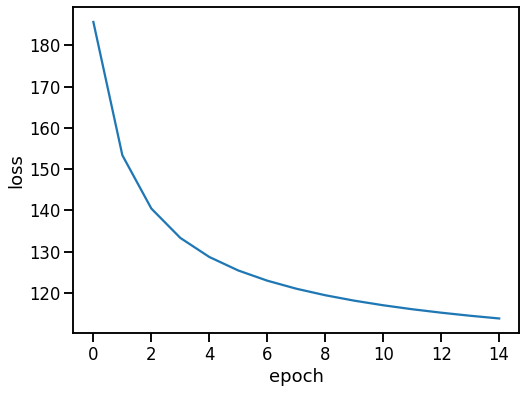

In [12]:
plt.figure(figsize=(8, 6))
sns.lineplot(x='epoch', y='loss', data=df_loss)

#### Generate new samples

In [13]:
# inp = tf.random.normal(shape=(4, latent_dim), mean=10)
inp = np.asarray([[0.] * latent_dim])

inp[0][4] = -2


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



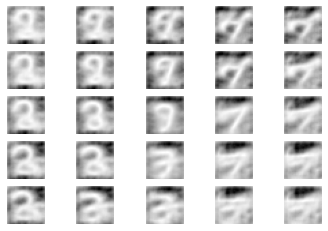

In [14]:
N = 5
fig, ax_arr = plt.subplots(N, N)

for i, x in enumerate(np.linspace(-10, 10, N)):
    for j, y in enumerate(np.linspace(-10, 10, N)):
        ax = ax_arr[i, j]
        inp[0][:2] = np.random.normal([x, y])

        img = autoencoder.sample(inp).numpy()

        ax.imshow(img[0,:,:,0], cmap='gray')
        ax.axis('off')

#### Check specific examples

In [15]:
features_sub = training_features[:10]
features_sub.shape

(10, 28, 28, 1)

In [16]:
original = tf.reshape(
    features_sub, (features_sub.shape[0], 28, 28))
reconstructed = tf.reshape(
    autoencoder(tf.constant(features_sub)),
    (features_sub.shape[0], 28, 28))

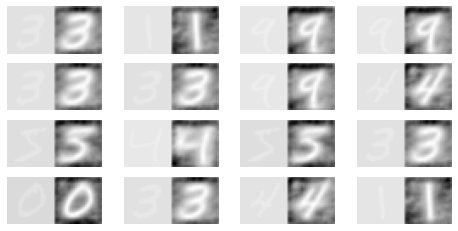

In [17]:
N = 16
fig, ax_list = plt.subplots(nrows=4, ncols=4, figsize=(8, 4))

for i, ax in enumerate(ax_list.ravel()):
    idx = np.random.randint(0, original.shape[0])

    img_orig = original.numpy()[idx]
    img_recon = reconstructed.numpy()[idx]

    img_concat = np.concatenate([img_orig, img_recon], axis=1)

    ax.imshow(img_concat, cmap='gray')
    ax.axis('off')

#### PCA

In [18]:
def do_PCA(X, ndim=2):
    pca = PCA(n_components=ndim)
    pca.fit(X)
    X_trans = pca.transform(X)
    print(pca.explained_variance_ratio_)
    return pd.DataFrame(X_trans, columns=[f'PC_{i}' for i in range(ndim)])

In [19]:
latent_features = autoencoder.encode(training_features)
latent_features_1d = np.concatenate(latent_features, axis=1)

df_latent = do_PCA(latent_features_1d)
df_latent['label'] = training_labels
df_latent['space'] = 'latent'

[0.22099474 0.11472965]


In [20]:
data_train_1d = training_features.reshape(
    training_features.shape[0],
    training_features.shape[1]*training_features.shape[2])

df_original = do_PCA(data_train_1d)
df_original['label'] = training_labels
df_original['space'] = 'original'

[0.09704716 0.07095958]


In [21]:
df_pca = pd.concat([df_original, df_latent])

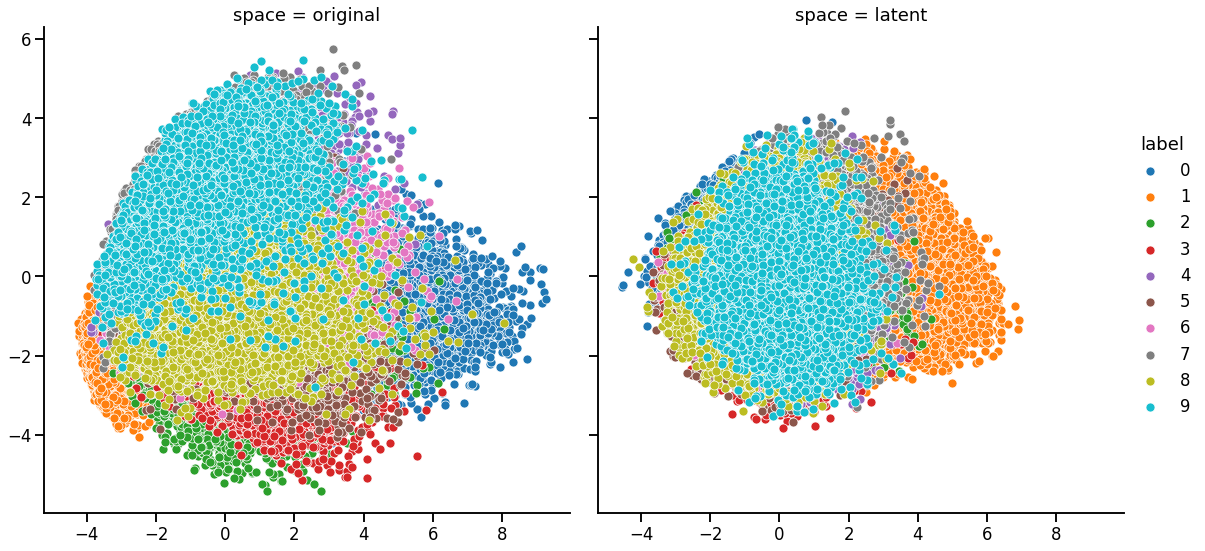

In [22]:
g = sns.FacetGrid(df_pca, col='space', hue='label', height=8, legend_out=True)
g.map_dataframe(sns.scatterplot, x='PC_0', y='PC_1', rasterized=True)
g.add_legend()